 # NYC Taxi Trip Analysis

[Dashboard](https://lookerstudio.google.com/reporting/72b3cf92-b1f6-477e-92f6-dc76135a2bb4)

---

# 1. Introduction
## 1.1 Background

New York City (NYC) is known for its bustling streets and vibrant culture, attracting millions of residents and tourists alike. One of the primary modes of transportation in NYC is the iconic yellow taxi, which plays a crucial role in facilitating movement across the city's boroughs. With thousands of taxis operating around the clock, understanding the dynamics of taxi trips in NYC is essential for transportation planning, infrastructure development, and improving the overall transportation experience for residents and visitors.

## 1.2 Objective

The objective of this analysis is to explore and analyze the patterns and trends of taxi trips in New York City. By examining various aspects such as trip duration, distance traveled, fare amounts, and passenger occupancy, we aim to gain insights into the following:

1. **Temporal Patterns**: Identify peak hours and periods of high demand for taxi services throughout the day and week.

2. **Trip Characteristics**: Investigate the average trip duration, distance traveled, and fare amounts to understand the typical patterns of taxi usage in NYC.

3. **Passenger Behavior**: Explore passenger behavior, including solo travel versus group travel, preferred payment methods, and instances of disputed fares or refunds.

By achieving these objectives, we aim to provide valuable insights for policymakers, urban planners, transportation authorities, and taxi service providers to enhance the efficiency, accessibility, and sustainability of taxi services in New York City. Additionally, this analysis will serve as a foundation for further research and initiatives aimed at improving the overall transportation infrastructure and experience in one of the world's most dynamic cities.

---

# 2. Data Loading

The dataset used is a dataset of taxi trips in NYC in January 2023.[ Source](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [79]:
# Import Library
import pyarrow
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# check version
print(f"numpy version = {np.__version__}")
print(f"pyarrow version = {pyarrow.__version__}")
print(f"pandas version = {pd.__version__}")
print(f"requests version = {requests.__version__}")

numpy version = 1.26.2
pyarrow version = 14.0.2
pandas version = 2.1.4
requests version = 2.31.0


In [81]:
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
parquet_name = 'output.parquet'
csv_name = 'output.csv'

In [82]:
# Make the request to download the file
response = requests.get(url)

# Get the total file size in bytes
total_size = int(response.headers.get('content-length', 0))

# Open the file in binary write mode to save the downloaded content
with open(parquet_name, 'wb') as f:
    # Use tqdm to create a progress bar
    with tqdm(total=total_size, unit='B', unit_scale=True, desc=url.split('/')[-1]) as pbar:
        # Iterate over the content of the response in chunks and write it to the file
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
            # Update the progress bar
            pbar.update(len(chunk))

print(f'File Size= {total_size} bytes')
print("Download completed successfully!")

yellow_tripdata_2023-01.parquet: 100%|██████████| 47.7M/47.7M [00:00<00:00, 52.0MB/s]


File Size= 47673370 bytes
Download completed successfully!


In [83]:
# Read the Parquet file into a DataFrame
df_parquet = pd.read_parquet(parquet_name)
len(df_parquet)

3066766

In [84]:
# Create sample 
df = df_parquet.sample(n=100000, random_state=42).reset_index(drop=True)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-29 17:52:02,2023-01-29 17:56:43,1.0,1.17,1.0,N,262,74,2,7.2,0.0,0.5,0.00,0.0,1.0,11.20,2.5,0.0
1,1,2023-01-08 15:57:24,2023-01-08 16:02:47,1.0,0.90,1.0,N,229,237,2,6.5,2.5,0.5,0.00,0.0,1.0,10.50,2.5,0.0
2,2,2023-01-21 19:38:01,2023-01-21 19:45:02,1.0,0.95,1.0,N,45,261,1,7.9,0.0,0.5,2.38,0.0,1.0,14.28,2.5,0.0
3,2,2023-01-23 16:07:31,2023-01-23 16:26:46,5.0,0.88,1.0,N,237,141,1,16.3,2.5,0.5,1.50,0.0,1.0,24.30,2.5,0.0
4,2,2023-01-26 21:21:08,2023-01-26 21:24:48,2.0,1.03,1.0,N,229,140,1,6.5,1.0,0.5,2.30,0.0,1.0,13.80,2.5,0.0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               100000 non-null  int64         
 1   tpep_pickup_datetime   100000 non-null  datetime64[us]
 2   tpep_dropoff_datetime  100000 non-null  datetime64[us]
 3   passenger_count        97714 non-null   float64       
 4   trip_distance          100000 non-null  float64       
 5   RatecodeID             97714 non-null   float64       
 6   store_and_fwd_flag     97714 non-null   object        
 7   PULocationID           100000 non-null  int64         
 8   DOLocationID           100000 non-null  int64         
 9   payment_type           100000 non-null  int64         
 10  fare_amount            100000 non-null  float64       
 11  extra                  100000 non-null  float64       
 12  mta_tax                100000 non-null  float

**Data Description**

1. `VendorID`	= A code indicating the TPEP provider that provided the record.

    1= Creative Mobile Technologies, LLC; 

    2= VeriFone Inc.

2. `tpep_pickup_datetime`	= The date and time when the meter was engaged.

3. `tpep_dropoff_datetime` = The date and time when the meter was disengaged.
Passenger_count	The number of passengers in the vehicle. This is a driver-entered value.

4. `Trip_distance` = The elapsed trip distance in miles reported by the taximeter.

5. `PULocationID` = TLC Taxi Zone in which the taximeter was engaged.

6. `DOLocationID` = TLC Taxi Zone in which the taximeter was disengaged.

7. `RateCodeID` = The final rate code in effect at the end of the trip.
    1= Standard rate

    2=JFK

    3=Newark

    4=Nassau or Westchester

    5=Negotiated fare

    6=Group ride

8. `Store_and_fwd_flag` = This flag indicates whether the trip record was held in vehicle memory before sending to the vendor.

    Y= store and forward trip

    N= not a store and forward trip

9. `Payment_type` = A numeric code signifying how the passenger paid for the trip.

    1= Credit card

    2= Cash

    3= No charge

    4= Dispute

    5= Unknown

    6= Voided trip

10. `Fare_amount` =	The time-and-distance fare calculated by the meter.

11. `Extra` =	Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 rush hour and overnight charges.

12. `MTA_tax` =	0.50 MTA tax that is automatically triggered based on the metered rate in use.

13. `Improvement_surcharge`	= 0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

14. `Tip_amount` = Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

15. `Tolls_amount` = Total amount of all tolls paid in trip.

16. `Total_amount` = The total amount charged to passengers. Does not include cash tips.

17. `Congestion_Surcharge` = Total amount collected in trip for NYS congestion surcharge.

19. `Airport_fee` =	1.25 for pick up only at LaGuardia and John F. Kennedy Airports.                              |


In [86]:
# Calculate percentage of missing values in each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Print the percentage of missing values for each column
print(missing_percentage)

VendorID                 0.000
tpep_pickup_datetime     0.000
tpep_dropoff_datetime    0.000
passenger_count          2.286
trip_distance            0.000
RatecodeID               2.286
store_and_fwd_flag       2.286
PULocationID             0.000
DOLocationID             0.000
payment_type             0.000
fare_amount              0.000
extra                    0.000
mta_tax                  0.000
tip_amount               0.000
tolls_amount             0.000
improvement_surcharge    0.000
total_amount             0.000
congestion_surcharge     2.286
airport_fee              2.286
dtype: float64


## 2.2 Descriptive Statistics

In [87]:
# Descriptive Statistics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
VendorID,100000.0,1.73224,1.0,1.0,2.0,2.0,2.0,0.442794
tpep_pickup_datetime,100000,2023-01-17 01:25:12.117169,2022-10-25 09:06:23,2023-01-09 17:08:23.750000,2023-01-17 09:58:57.500000,2023-01-24 17:18:00,2023-01-31 23:59:47,NaN
tpep_dropoff_datetime,100000,2023-01-17 01:40:51.655580,2022-10-25 09:21:36,2023-01-09 17:24:30.250000,2023-01-17 10:14:43,2023-01-24 17:35:01,2023-02-01 22:17:19,NaN
passenger_count,97714.0,1.362701,0.0,1.0,1.0,1.0,6.0,0.892905
trip_distance,100000.0,3.464649,0.0,1.06,1.79,3.3325,7729.75,26.091789
RatecodeID,97714.0,1.503254,1.0,1.0,1.0,1.0,99.0,6.515566
PULocationID,100000.0,166.36925,1.0,132.0,162.0,234.0,265.0,64.301743
DOLocationID,100000.0,164.37428,1.0,114.0,162.0,234.0,265.0,69.821038
payment_type,100000.0,1.19473,0.0,1.0,1.0,1.0,4.0,0.528633
fare_amount,100000.0,18.311659,-231.9,8.6,12.8,20.5,400.0,17.581057


---

# 3. Exploratory Data Analysis and Data Preprocessing

## 3.1 Missing Value

In [88]:
df_filter = df.copy()
# Calculate percentage of missing values in each column
missing_percentage = (df_filter.isnull().sum() / len(df_filter)) * 100

# Print the percentage of missing values for each column
print(missing_percentage)

VendorID                 0.000
tpep_pickup_datetime     0.000
tpep_dropoff_datetime    0.000
passenger_count          2.286
trip_distance            0.000
RatecodeID               2.286
store_and_fwd_flag       2.286
PULocationID             0.000
DOLocationID             0.000
payment_type             0.000
fare_amount              0.000
extra                    0.000
mta_tax                  0.000
tip_amount               0.000
tolls_amount             0.000
improvement_surcharge    0.000
total_amount             0.000
congestion_surcharge     2.286
airport_fee              2.286
dtype: float64


In [89]:
# Drop rows with missing values
df_filter.dropna(inplace=True)

# Calculate percentage of missing values in each column
missing_percentage = (df_filter.isnull().sum() / len(df_filter)) * 100

# Print the percentage of missing values for each column
print(missing_percentage)

VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
dtype: float64


## 3.2 Trip Distance

- **Histogram and Boxplot**

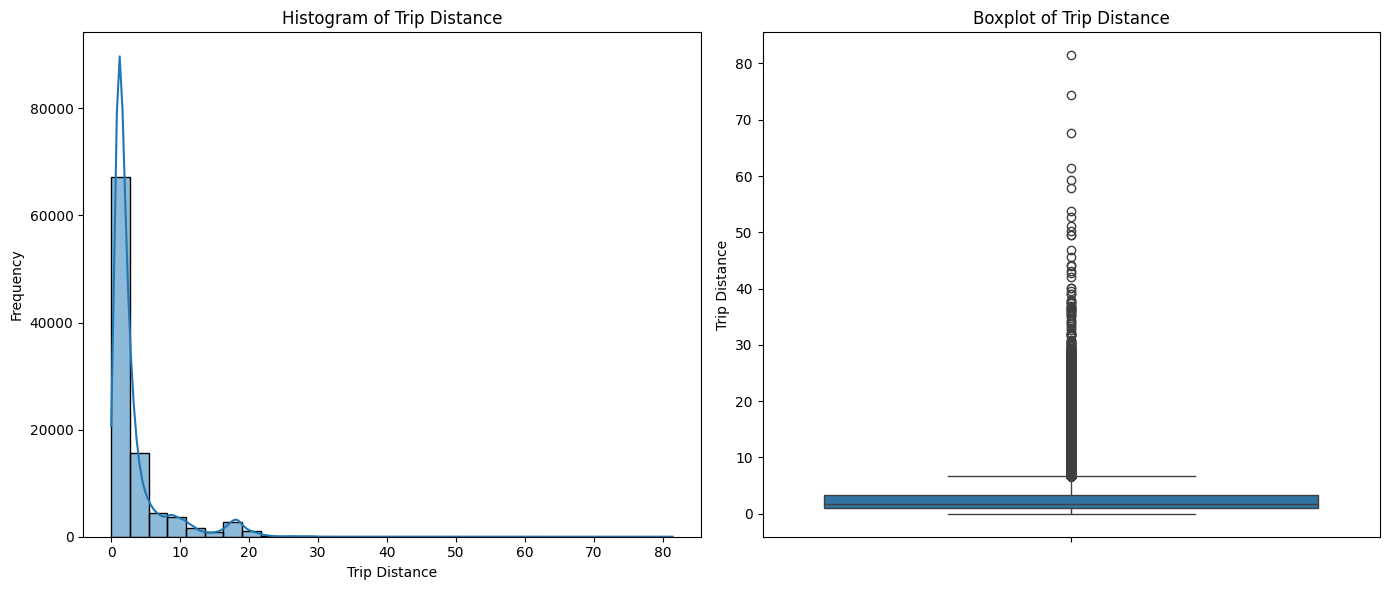

In [90]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of trip distance
sns.histplot(df_filter['trip_distance'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Trip Distance')
axes[0].set_xlabel('Trip Distance')
axes[0].set_ylabel('Frequency')

# Plot boxplot of trip distance
sns.boxplot(data=df_filter, y='trip_distance', ax=axes[1])
axes[1].set_title('Boxplot of Trip Distance')
axes[1].set_ylabel('Trip Distance')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [91]:
# Calculate the first quartile (Q1)
Q1 = df_filter['trip_distance'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['trip_distance'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['trip_distance'] < lower_bound) | (df_filter['trip_distance'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'trip_distance' column:", df_filter['trip_distance'].skew())

Percentage of outliers: 12.914219047424117
Skewness of 'trip_distance' column: 2.915251066485175


C:\Users\luay9\AppData\Local\Temp\ipykernel_13948\2588092609.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_distance_groups = df_filter.groupby('trip_distance_group').size()


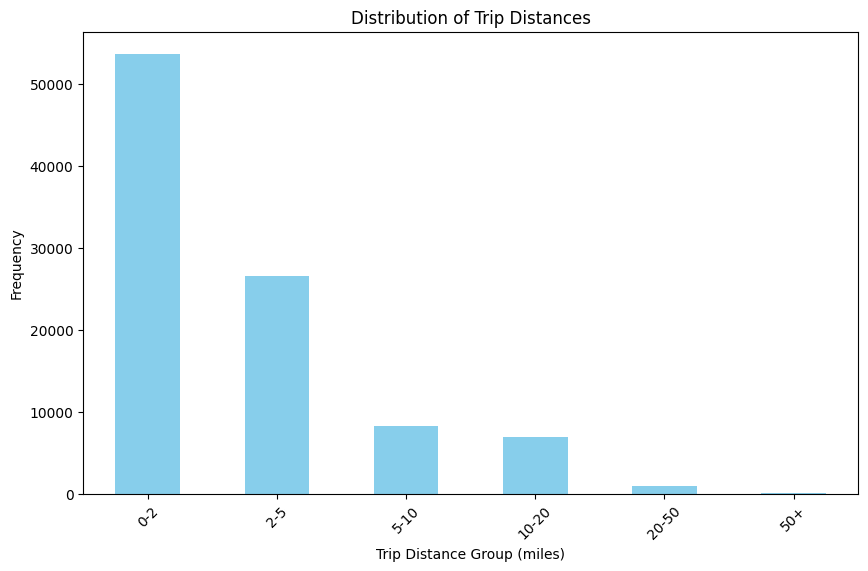

In [92]:
# Define bin edges
bin_edges = [0, 2, 5, 10, 20, 50, np.inf]  

# Define bin labels
bin_labels = ['0-2', '2-5', '5-10', '10-20', '20-50', '50+']

# Create a new column with bins
df_filter['trip_distance_group'] = pd.cut(df_filter['trip_distance'], bins=bin_edges, labels=bin_labels)

# Group the data by trip distance groups
trip_distance_groups = df_filter.groupby('trip_distance_group').size()

# Plot the distribution of trip distances
plt.figure(figsize=(10, 6))
trip_distance_groups.plot(kind='bar', color='skyblue')
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance Group (miles)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

- **Filter by Trip Distance <= 50 miles and Trip Distance > 0**

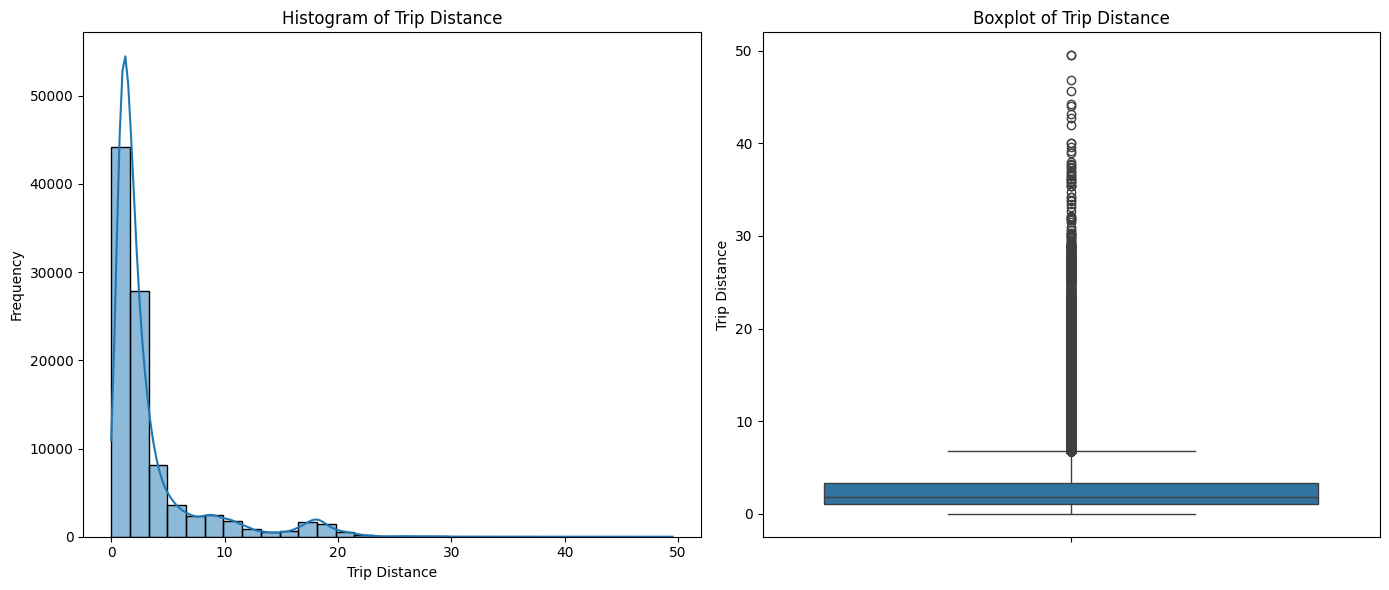

In [93]:
# Filter the DataFrame based on trip distance
df_filter = df_filter[df_filter['trip_distance'] <= 50]

# Filter the DataFrame based on trip distance
df_filter = df_filter[df_filter['trip_distance'] > 0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of trip distance
sns.histplot(df_filter['trip_distance'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Trip Distance')
axes[0].set_xlabel('Trip Distance')
axes[0].set_ylabel('Frequency')

# Plot boxplot of trip distance
sns.boxplot(data=df_filter, y='trip_distance', ax=axes[1])
axes[1].set_title('Boxplot of Trip Distance')
axes[1].set_ylabel('Trip Distance')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [94]:
# Calculate the first quartile (Q1)
Q1 = df_filter['trip_distance'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['trip_distance'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['trip_distance'] < lower_bound) | (df_filter['trip_distance'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'trip_distance' column:", df_filter['trip_distance'].skew())

Percentage of outliers: 12.921260904291183
Skewness of 'trip_distance' column: 2.728267407488463


C:\Users\luay9\AppData\Local\Temp\ipykernel_13948\1299241828.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_distance_groups = df_filter.groupby('trip_distance_group').size()


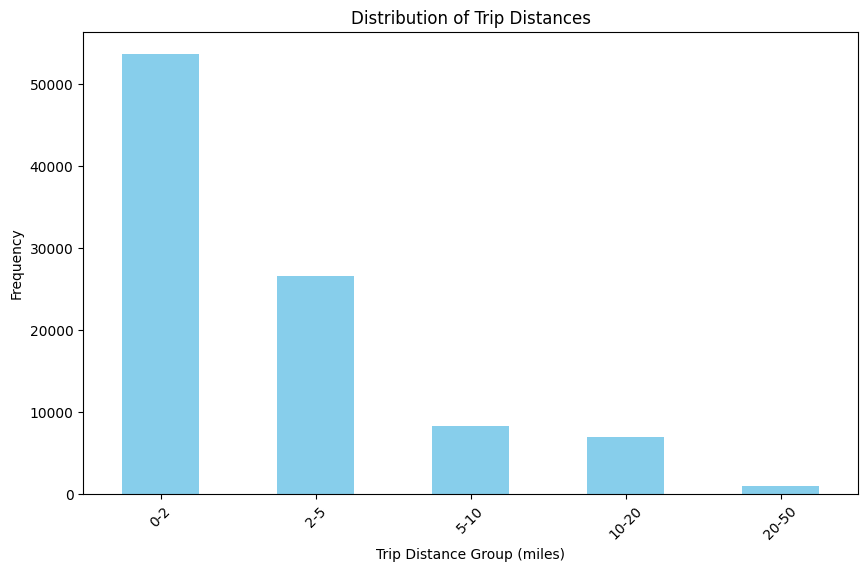

In [95]:
# Define bin edges
bin_edges = [0, 2, 5, 10, 20, 50]  

# Define bin labels
bin_labels = ['0-2', '2-5', '5-10', '10-20', '20-50']

# Create a new column with bins
df_filter['trip_distance_group'] = pd.cut(df_filter['trip_distance'], bins=bin_edges, labels=bin_labels)

# Group the data by trip distance groups
trip_distance_groups = df_filter.groupby('trip_distance_group').size()

# Plot the distribution of trip distances
plt.figure(figsize=(10, 6))
trip_distance_groups.plot(kind='bar', color='skyblue')
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance Group (miles)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

While most taxi users travel short distances (0 - 2 miles), there are also taxi users who travel distances greater than 50 miles. 
Several factors may lead taxi users to opt for long-distance travel exceeding 50 miles:

1. **Convenience**: Taxis offer door-to-door service, making them convenient for travelers who may not have access to their vehicles or prefer not to drive long distances themselves.

2. **Lack of Alternatives**: In areas with limited or inadequate public transportation options, taxis may be the most accessible mode of transportation for long-distance travel, particularly for individuals without personal vehicles or those unable to use other transportation services.

3. **Accessibility**: Taxis can accommodate passengers with limited mobility or special needs, making them a preferred choice for individuals who require assistance or accommodations during long journeys.

## 3.3 Fare Amount

- **Histogram and Boxplot**

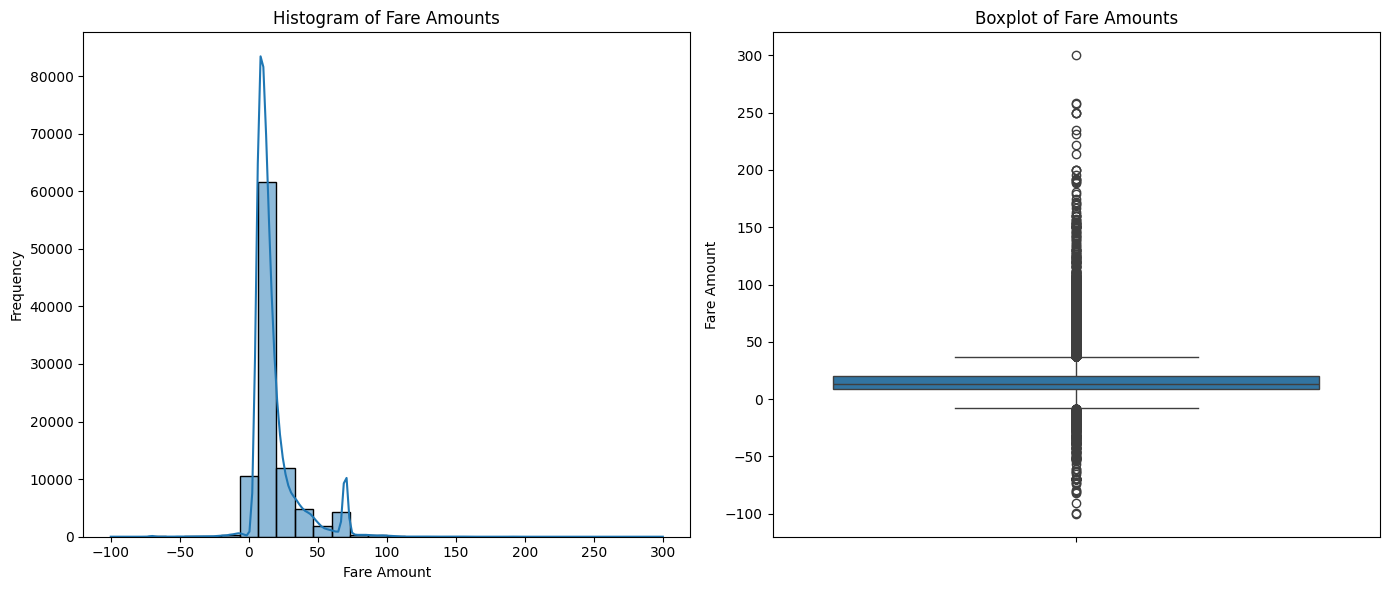

In [96]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of fare amount
sns.histplot(df_filter['fare_amount'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Fare Amounts')
axes[0].set_xlabel('Fare Amount')
axes[0].set_ylabel('Frequency')

# Plot boxplot of fare amount
sns.boxplot(data=df_filter, y='fare_amount', ax=axes[1])
axes[1].set_title('Boxplot of Fare Amounts')
axes[1].set_ylabel('Fare Amount')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [97]:
# Calculate the first quartile (Q1)
Q1 = df_filter['fare_amount'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['fare_amount'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['fare_amount'] < lower_bound) | (df_filter['fare_amount'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'fare_amount' column:", df_filter['fare_amount'].skew())

Percentage of outliers: 11.005424917277791
Skewness of 'fare_amount' column: 2.4932367881898645


C:\Users\luay9\AppData\Local\Temp\ipykernel_13948\2470015503.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filter, x='fare_amount_group', order=bin_labels, palette='viridis')


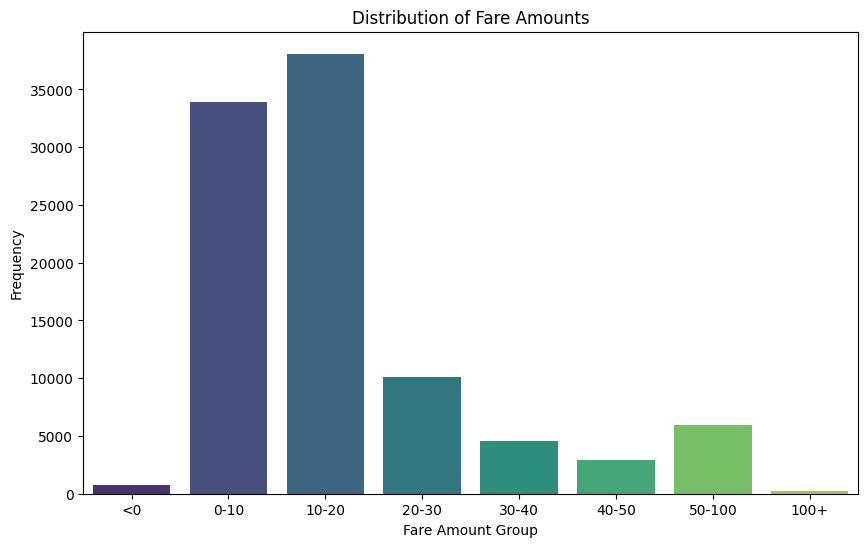

In [98]:
# Define bin edges
bin_edges = [-np.inf, 0, 10, 20, 30, 40, 50, 100, np.inf]   # Define your desired bin edges

# Define bin labels
bin_labels = ['<0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+']

# Create a new column with bins
df_filter['fare_amount_group'] = pd.cut(df_filter['fare_amount'], bins=bin_edges, labels=bin_labels)

# Plot the distribution of fare amounts
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filter, x='fare_amount_group', order=bin_labels, palette='viridis')
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount Group')
plt.ylabel('Frequency')
plt.show()

- **Filter Taxi Fare > 0**

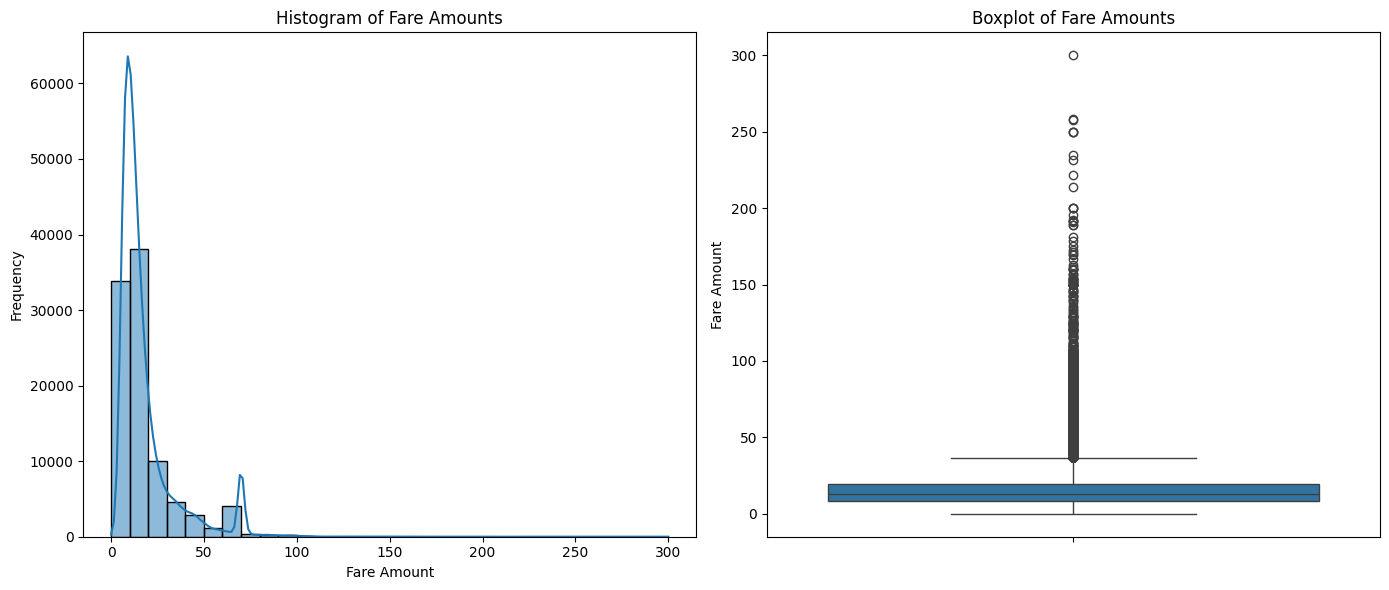

In [99]:
# Filter the DataFrame based on fare amount
df_filter = df_filter[df_filter['fare_amount'] > 0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of fare amount
sns.histplot(df_filter['fare_amount'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Fare Amounts')
axes[0].set_xlabel('Fare Amount')
axes[0].set_ylabel('Frequency')

# Plot boxplot of fare amount
sns.boxplot(data=df_filter, y='fare_amount', ax=axes[1])
axes[1].set_title('Boxplot of Fare Amounts')
axes[1].set_ylabel('Fare Amount')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [100]:
# Calculate the first quartile (Q1)
Q1 = df_filter['fare_amount'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['fare_amount'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['fare_amount'] < lower_bound) | (df_filter['fare_amount'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'fare_amount' column:", df_filter['fare_amount'].skew())

Percentage of outliers: 10.5859599602739
Skewness of 'fare_amount' column: 2.7840096958887353


C:\Users\luay9\AppData\Local\Temp\ipykernel_13948\897287736.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filter, x='fare_amount_group', order=bin_labels, palette='viridis')


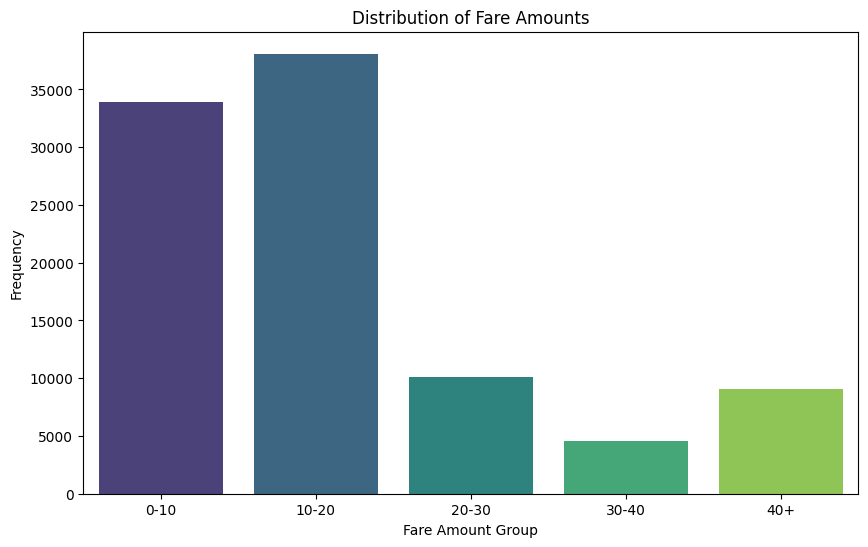

In [101]:
# Define bin edges
bin_edges = [0, 10, 20, 30, 40, np.inf]   # Define your desired bin edges

# Define bin labels
bin_labels = ['0-10', '10-20', '20-30', '30-40','40+']

# Create a new column with bins
df_filter['fare_amount_group'] = pd.cut(df_filter['fare_amount'], bins=bin_edges, labels=bin_labels)

# Plot the distribution of fare amounts
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filter, x='fare_amount_group', order=bin_labels, palette='viridis')
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount Group')
plt.ylabel('Frequency')
plt.show()

Most taxi users typically pay fares ranging from 0 to 20 USD, but there are also instances of negative taxi fares. A negative fare, which occasionally occurs, usually indicates a credit or refund issued to the passenger.

## 3.4 Passenger Count

- **Histogram and Boxplot**

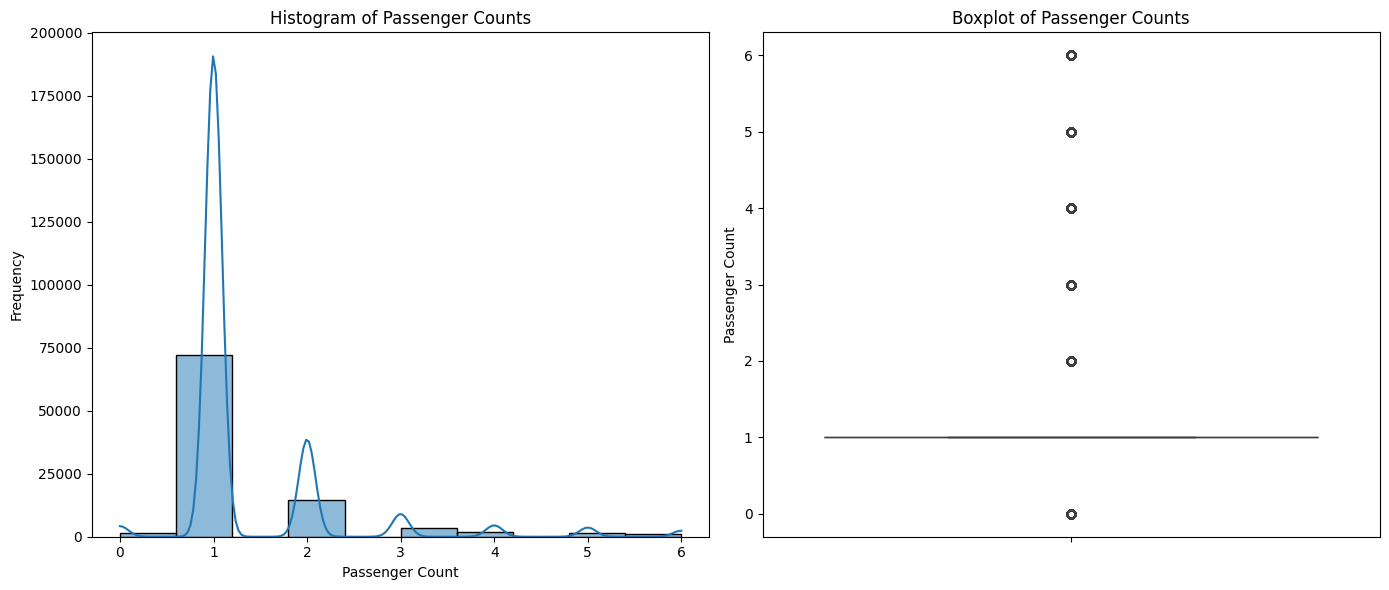

In [102]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of passenger count
sns.histplot(df_filter['passenger_count'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Passenger Counts')
axes[0].set_xlabel('Passenger Count')
axes[0].set_ylabel('Frequency')

# Plot boxplot of passenger count
sns.boxplot(data=df_filter, y='passenger_count', ax=axes[1])
axes[1].set_title('Boxplot of Passenger Counts')
axes[1].set_ylabel('Passenger Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [103]:
# Calculate the first quartile (Q1)
Q1 = df_filter['passenger_count'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['passenger_count'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['passenger_count'] < lower_bound) | (df_filter['passenger_count'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'passenger_count' column:", df_filter['passenger_count'].skew())

Percentage of outliers: 24.636453922952274
Skewness of 'passenger_count' column: 2.8727910457647696


- **Filter by Minimum Passenger > 0 and Minimum Passenger <= 4** [(source)](https://www.takewalks.com/blog/nyc-taxis#:~:text=The%20maximum%20number%20of%20passengers,to%20sit%20beside%20the%20driver.)

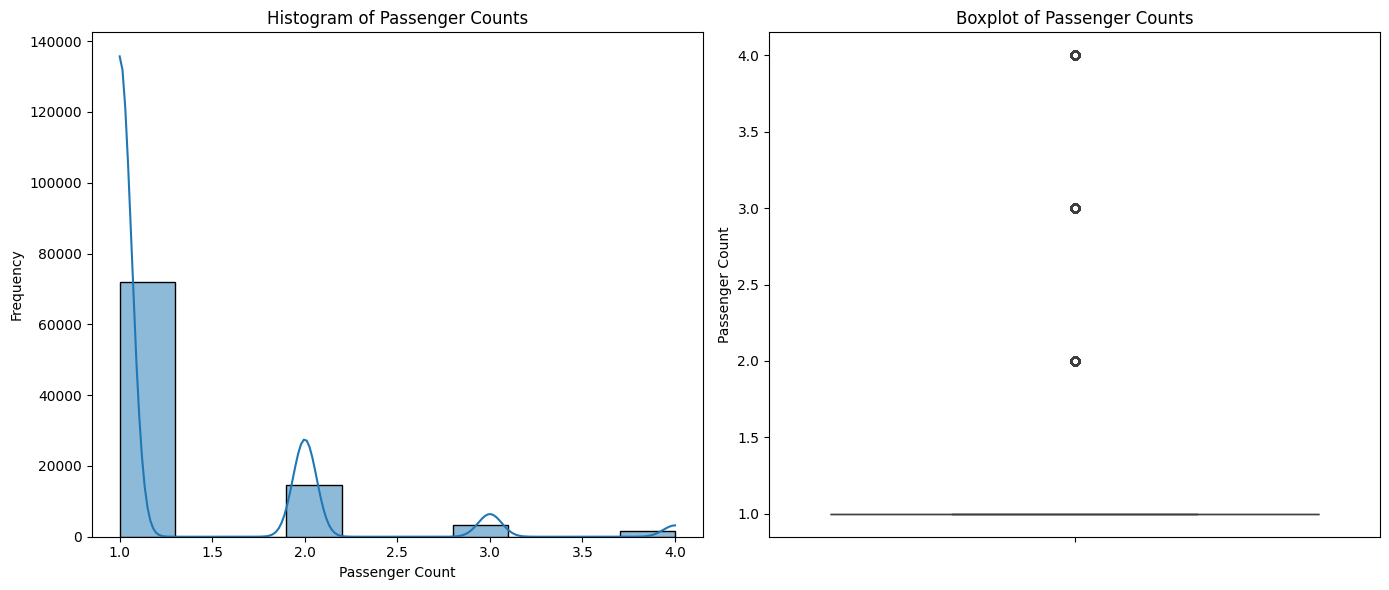

In [104]:
# Filter the DataFrame based on passenger count
df_filter = df_filter[(df_filter['passenger_count'] > 0) & (df_filter['passenger_count'] <= 4)]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of passenger count
sns.histplot(df_filter['passenger_count'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Passenger Counts')
axes[0].set_xlabel('Passenger Count')
axes[0].set_ylabel('Frequency')

# Plot boxplot of passenger count
sns.boxplot(data=df_filter, y='passenger_count', ax=axes[1])
axes[1].set_title('Boxplot of Passenger Counts')
axes[1].set_ylabel('Passenger Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [105]:
# Calculate the first quartile (Q1)
Q1 = df_filter['passenger_count'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['passenger_count'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['passenger_count'] < lower_bound) | (df_filter['passenger_count'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'passenger_count' column:", df_filter['passenger_count'].skew())

Percentage of outliers: 21.469966665940436
Skewness of 'passenger_count' column: 2.4292408033514183


Most taxi users travel alone, but there are also taxi trips with either no passengers or more than five passengers. 
Empty taxi trips, where a taxi operates without any passengers, can occur due to several reasons:

1. **Deadheading**: Taxi driver returns to a high-demand area without passengers after dropping off a fare in a low-demand area. 

2. **Shift Changes**: Taxi drivers might need to relocate their vehicles to specific locations for shift changes or breaks, resulting in empty trips between locations.

3. **Time of Day**: During off-peak hours or late at night when demand is low, taxis may circulate without passengers, leading to empty trips.

4. **Ride Refusals**: Sometimes, taxi drivers may refuse certain rides based on destination or other factors, leading to empty trips if they cannot find another fare immediately.

Large group taxi trips, on the other hand, can occur due to various reasons:

1. **Events and Special Occasions**: Groups traveling together for events such as weddings, parties, or corporate gatherings may require taxis to accommodate everyone in the group.

2. **Tourism**: In tourist-heavy areas, families or groups of tourists may opt for taxis to explore the city together.

3. **Airport Transfers**: Large families or groups traveling to or from airports may require taxis to transport them along with their luggage.

4. **Public Transportation Alternatives**: In cases where public transportation options are limited or impractical for large groups, taxis become a convenient alternative.

## 3.5 Pickup and Dropoff Date Time

- **Start Date From 2023-01-01**

In [106]:
# Convert string to datetime for comparison
start_date = pd.to_datetime('2023-01-01')

# Filter the DataFrame based on pickup datetime
df_filter = df_filter[df_filter['tpep_pickup_datetime'] >= start_date]
df_filter['tpep_pickup_datetime'].min()

Timestamp('2023-01-01 00:01:58')

In [107]:
df_filter['pickup_day'] = df_filter['tpep_pickup_datetime'].dt.day_name()
df_filter['pickup_hour'] = df_filter['tpep_pickup_datetime'].dt.hour
df_filter['dropoff_day'] = df_filter['tpep_dropoff_datetime'].dt.day_name()
df_filter['dropoff_hour'] = df_filter['tpep_dropoff_datetime'].dt.hour

# Calculate frequency of each category
pickup_day_frequency = df_filter['pickup_day'].value_counts()
pickup_hour_frequency = df_filter['pickup_hour'].value_counts()
dropoff_day_frequency = df_filter['dropoff_day'].value_counts()
dropoff_hour_frequency = df_filter['dropoff_hour'].value_counts()

1. **By Day of Week**

C:\Users\luay9\AppData\Local\Temp\ipykernel_13948\588151610.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filter, x='pickup_day', order=pickup_day_frequency.index, palette=custom_palette)


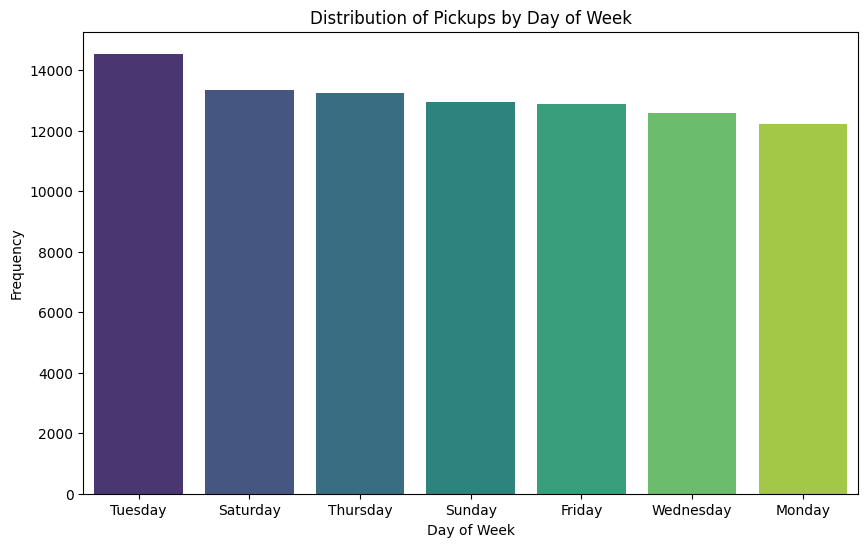

In [108]:
# color palette based on frequency
custom_palette = sns.color_palette("viridis", len(pickup_day_frequency))

# Distribution of pickups by day of week
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filter, x='pickup_day', order=pickup_day_frequency.index, palette=custom_palette)
plt.title('Distribution of Pickups by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.show()

C:\Users\luay9\AppData\Local\Temp\ipykernel_13948\36222469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filter, x='dropoff_day', order=dropoff_day_frequency.index, palette=custom_palette)


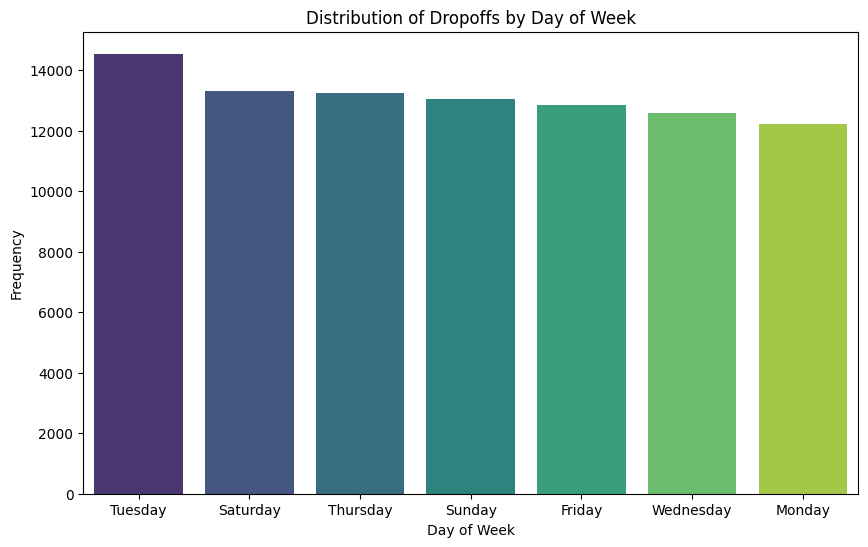

In [109]:
# color palette based on frequency
custom_palette = sns.color_palette("viridis", len(dropoff_day_frequency))

# Distribution of dropoffs by day of week
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filter, x='dropoff_day', order=dropoff_day_frequency.index, palette=custom_palette)
plt.title('Distribution of Dropoffs by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.show()

2. **By Hour of Day**

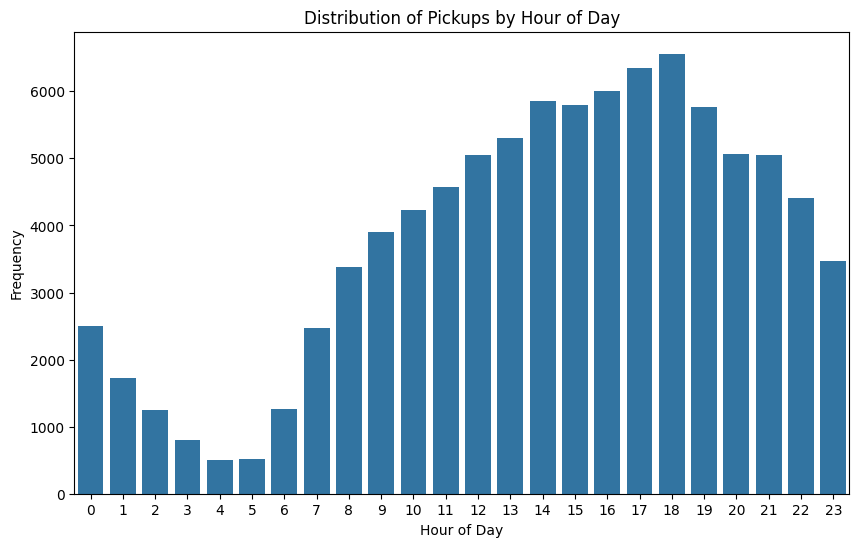

In [110]:
# Distribution of pickups by hour of day
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filter, x='pickup_hour')
plt.title('Distribution of Pickups by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

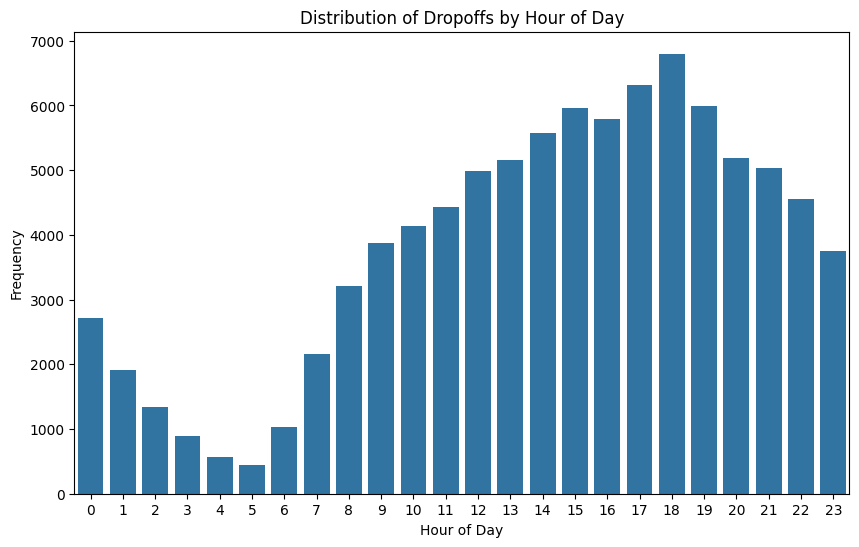

In [111]:
# Distribution of dropoffs by hour of day
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filter, x='dropoff_hour')
plt.title('Distribution of Dropoffs by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

When viewed during the day, the number of taxi trips is nearly equal. However, when examining taxi trips by the hour, the majority of them occur after work hours. This could imply several things, such as commuters relying on taxis to return home from work, increased demand for transportation services during leisure or social activities in the evening, or a shift-based economy where many individuals work later shifts. 

## 3.6 Trip Duration

- **Histogram and Boxplot**

<Figure size 1000x600 with 0 Axes>

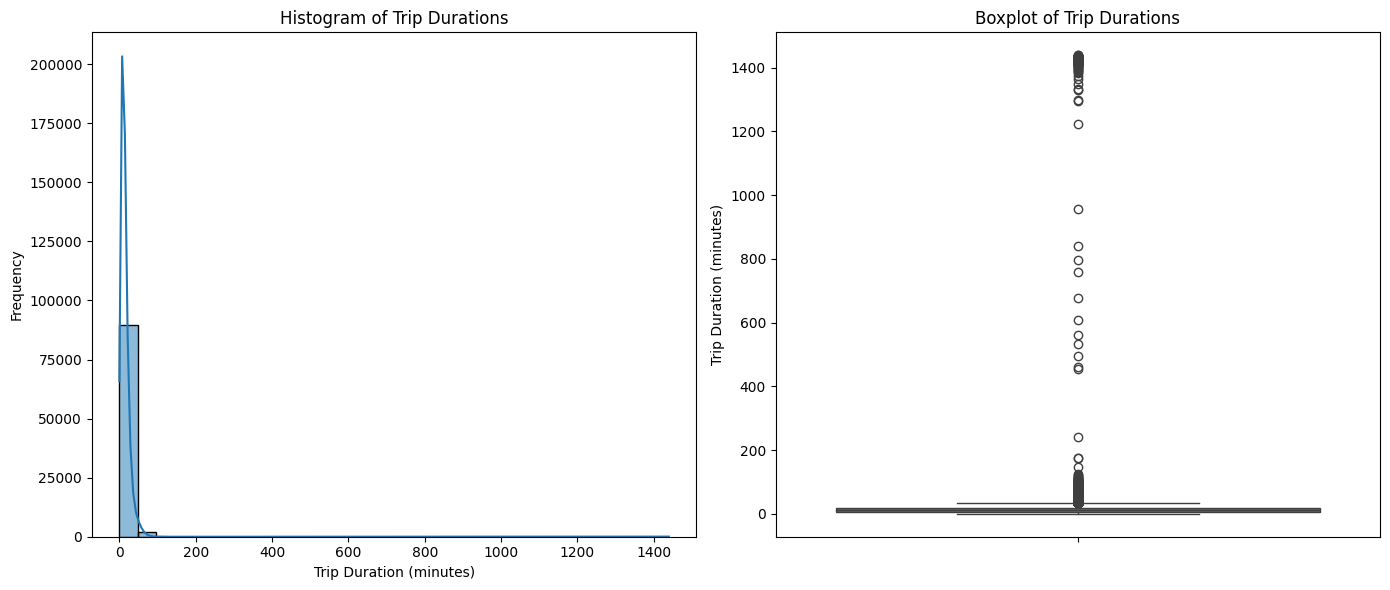

In [112]:
# Trip Duration
df_filter['trip_duration'] = (df_filter['tpep_dropoff_datetime'] - df_filter['tpep_pickup_datetime']).dt.total_seconds() / 60  # Convert to minutes
# Trip Duration > 0
df_filter = df_filter[df_filter['trip_duration'] > 0]

plt.figure(figsize=(10, 6))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of trip duration
sns.histplot(df_filter['trip_duration'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Trip Durations')
axes[0].set_xlabel('Trip Duration (minutes)')
axes[0].set_ylabel('Frequency')

# Plot boxplot of trip duration
sns.boxplot(data=df_filter, y='trip_duration', ax=axes[1])
axes[1].set_title('Boxplot of Trip Durations')
axes[1].set_ylabel('Trip Duration (minutes)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [113]:
# Calculate the first quartile (Q1)
Q1 = df_filter['trip_duration'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['trip_duration'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['trip_duration'] < lower_bound) | (df_filter['trip_duration'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'trip_duration' column:", df_filter['trip_duration'].skew())

Percentage of outliers: 5.662741167627161
Skewness of 'trip_duration' column: 30.67147637658185


C:\Users\luay9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:474: RuntimeWarning: invalid value encountered in subtract
  edges = res[orient].to_numpy() - widths / 2
C:\Users\luay9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:482: RuntimeWarning: invalid value encountered in multiply
  hist_norm = (heights * widths).sum()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


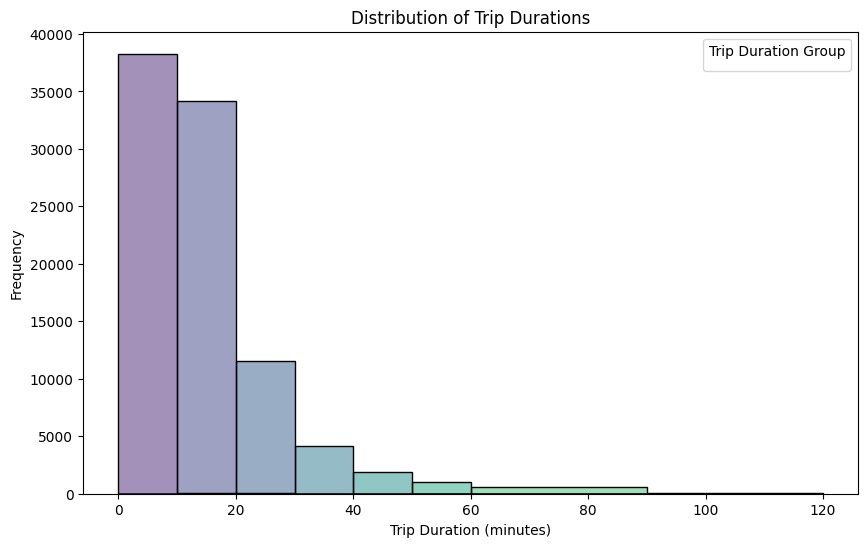

In [114]:
# Define bin edges
bin_edges = [0, 10, 20, 30, 40, 50, 60, 90, 120, np.inf]  # Define your desired bin edges

# Define bin labels
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-90', '90-120', '120+']

# Create a new column with bins
df_filter['trip_duration_group'] = pd.cut(df_filter['trip_duration'], bins=bin_edges, labels=bin_labels)

# Plot the distribution of trip durations using histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filter, x='trip_duration', bins=bin_edges, kde=True, hue='trip_duration_group', palette='viridis')
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.legend(title='Trip Duration Group')
plt.show()

Based on the duration of the trip, taxi users typically take 0 to 20 minutes to reach their destination, but there are also instances where taxi users take more than 240 minutes to reach their destination. Understanding that most taxi trips are completed within 20 minutes highlights the convenience and promptness that taxis offer for local or nearby destinations. 

## 3.7 Payment Types

- **Histogram and Boxplot**

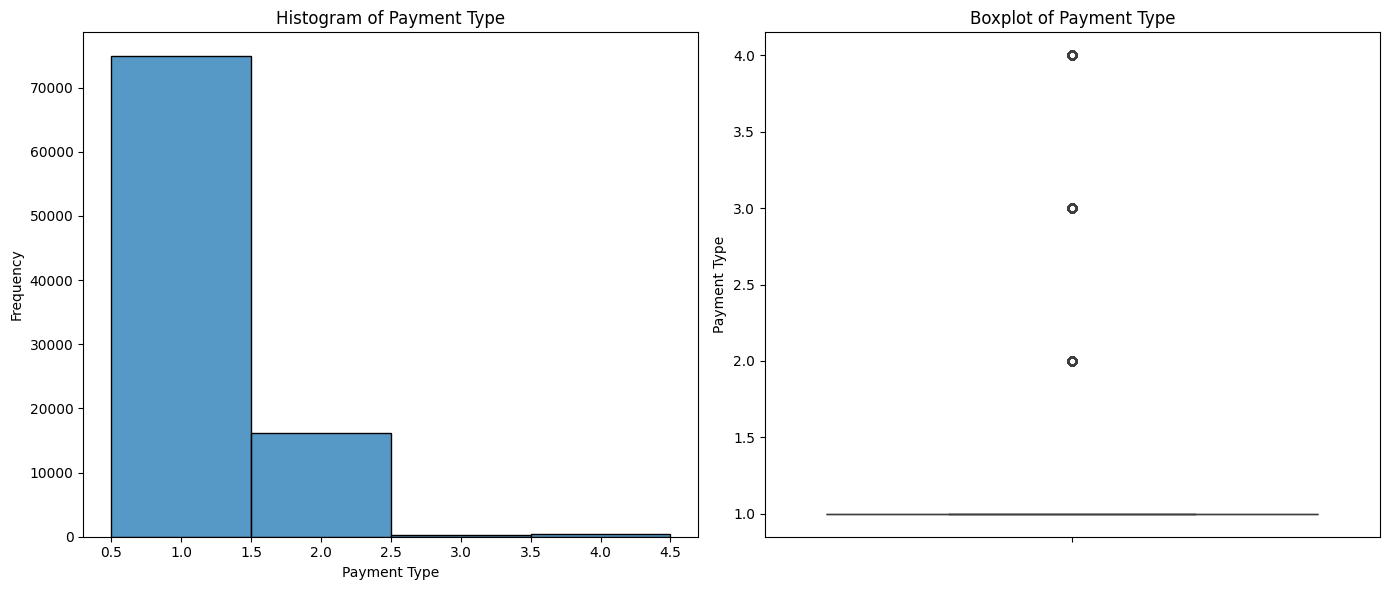

In [115]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of payment type
sns.histplot(df_filter['payment_type'], bins=5, discrete=True, ax=axes[0])
axes[0].set_title('Histogram of Payment Type')
axes[0].set_xlabel('Payment Type')
axes[0].set_ylabel('Frequency')

# Plot boxplot of payment type
sns.boxplot(data=df_filter, y='payment_type', ax=axes[1])
axes[1].set_title('Boxplot of Payment Type')
axes[1].set_ylabel('Payment Type')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [116]:
# Calculate the first quartile (Q1)
Q1 = df_filter['payment_type'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df_filter['payment_type'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((df_filter['payment_type'] < lower_bound) | (df_filter['payment_type'] > upper_bound)).sum()

# Calculate the percentage of outliers
percentage_outliers = (outliers_count / len(df_filter)) * 100
print("Percentage of outliers:", percentage_outliers)
print("Skewness of 'payment_type' column:", df_filter['payment_type'].skew())

Percentage of outliers: 18.43604632161494
Skewness of 'payment_type' column: 2.5092340107214377


Most taxi users utilize credit cards as a payment method, but there are also a small number of taxi users with No Charge and Dispute payment types. The presence of payment types such as No Charge and Dispute suggests instances where passengers may encounter unique circumstances or issues with their fares.

## 3.8 Fare Analysis

**1. Fare Amount and Trip Distance / Trip Duration**

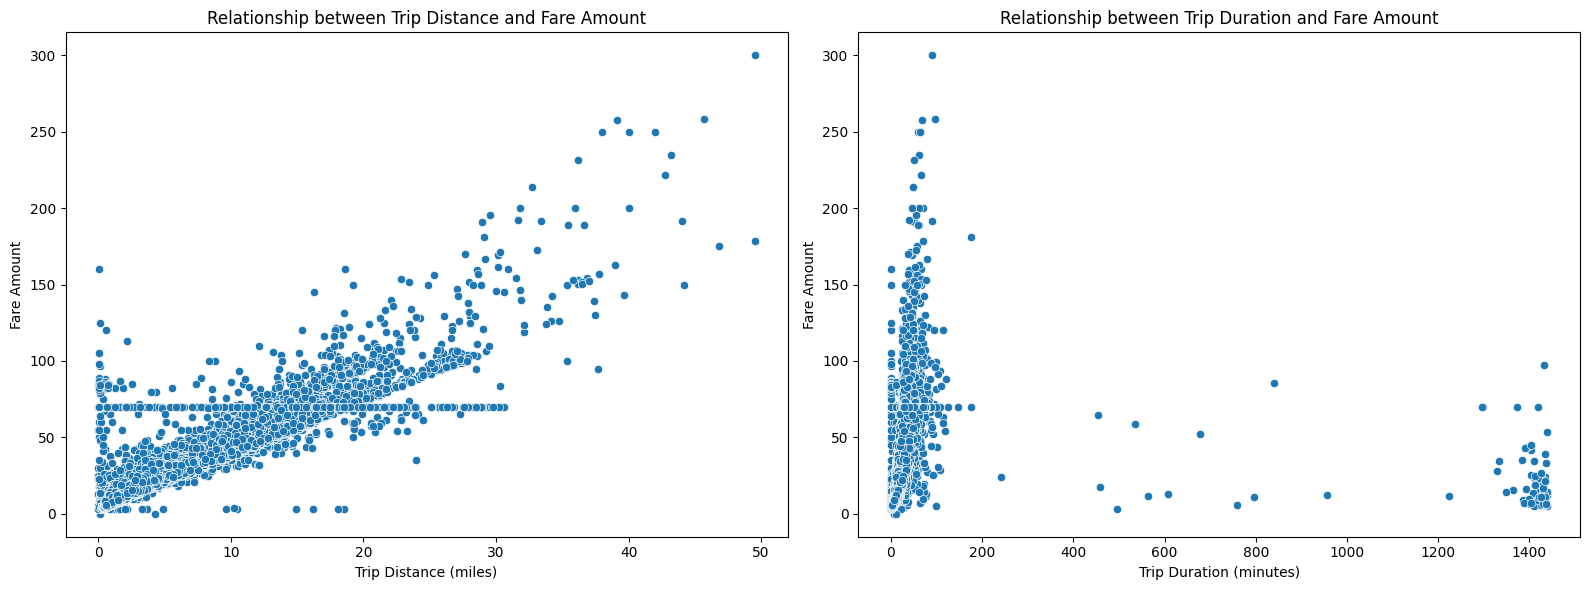

In [117]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot scatterplot for trip distance vs fare amount
sns.scatterplot(data=df_filter, x='trip_distance', y='fare_amount', ax=axes[0])
axes[0].set_title('Relationship between Trip Distance and Fare Amount')
axes[0].set_xlabel('Trip Distance (miles)')
axes[0].set_ylabel('Fare Amount')

# Plot scatterplot for trip duration vs fare amount
sns.scatterplot(data=df_filter, x='trip_duration', y='fare_amount', ax=axes[1])
axes[1].set_title('Relationship between Trip Duration and Fare Amount')
axes[1].set_xlabel('Trip Duration (minutes)')
axes[1].set_ylabel('Fare Amount')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Taxi fares are heavily influenced by the distance traveled and trip durations, with the average user typically opting for short-distance trips. The observation that the average user tends to opt for short-distance trips suggests that passengers prioritize convenience and efficiency, often choosing taxis for quick and localized transportation needs.

**2. Fare Amount and Time of Day**

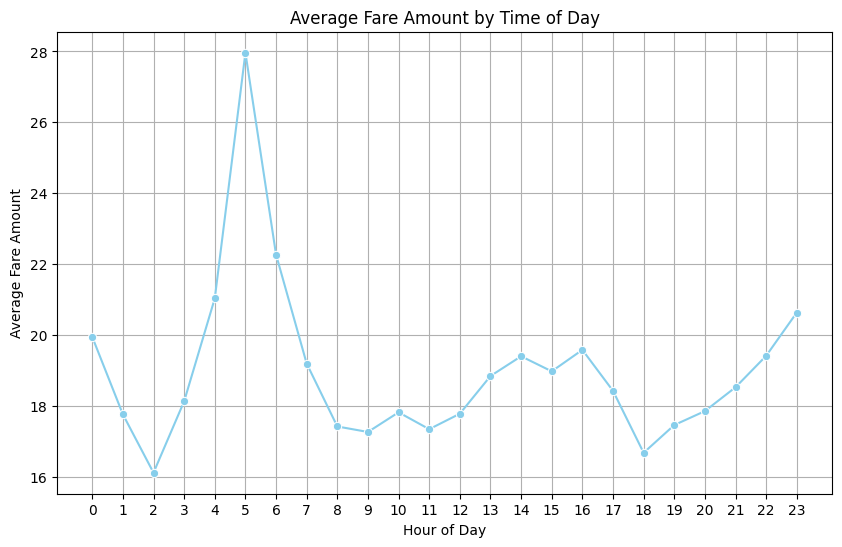

In [118]:
# Calculate average fare amount for each hour of the day
fare_by_hour = df_filter.groupby('pickup_hour')['fare_amount'].mean().reset_index()

# Plot the relationship between fare amount and time of day
plt.figure(figsize=(10, 6))
sns.lineplot(data=fare_by_hour, x='pickup_hour', y='fare_amount', marker='o', color='skyblue')
plt.title('Average Fare Amount by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.xticks(range(24))
plt.grid(True)
plt.show()

The occurrence of the highest average taxi fare at 11 PM suggests a notable trend in transportation demand during late-night hours. Several factors could contribute to this peak in fares. For instance, it may reflect the need for transportation to airports or train stations for early morning travel, such as flights or early commutes. Additionally, it might indicate higher fares due to limited availability of public transportation options during these hours, leading to increased reliance on taxis for early morning journeys

## 3.9 Save File to CSV

In [119]:
# Calculate percentage of missing values in each column
missing_percentage = (df_filter.isnull().sum() / len(df_filter)) * 100

# Print the percentage of missing values for each column
print(missing_percentage)

VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
trip_distance_group      0.0
fare_amount_group        0.0
pickup_day               0.0
pickup_hour              0.0
dropoff_day              0.0
dropoff_hour             0.0
trip_duration            0.0
trip_duration_group      0.0
dtype: float64


In [120]:
# Save to CSV
df_filter.to_csv(csv_name)

In [121]:
len(df_filter)

91793

---

# 4. Conclusion and Recommendation

Based on Exploratory Data Analysis: 

1. While most taxi users travel short distances (0 - 2 miles), there are also taxi users who travel distances greater than 50 miles. 

2. Taxi fares are heavily influenced by the distance traveled and trip durations, with the average user typically opting for short-distance trips.

3. Most taxi users travel alone, but there are also taxi trips with either no passengers or more than five passengers.

4. When viewed during the day, the number of taxi trips is nearly equal. However, when examining taxi trips by the hour, the majority of them occur after work hours

5. Taxi users typically take 0 to 20 minutes to reach their destination, but there are also instances where taxi users take more than 240 minutes to reach their destination.

6. Most taxi users utilize credit cards as a payment method, but there are also a small number of taxi users with No Charge and Dispute payment types.

7. Most taxi users typically pay fares ranging from 0 to 20 USD, but there are also instances of negative taxi fares.

8. The occurrence of the highest average taxi fare at 11 PM suggests a notable trend in transportation demand during late-night hours. Several factors could contribute to this peak in fares.

Based on the insights gathered from our analysis of NYC taxi trips, we propose the following recommendations to enhance the efficiency and effectiveness of taxi services in New York City:

1. **Optimize Fleet Allocation**: Utilize real-time data analytics to allocate taxi fleets strategically, ensuring that vehicles are deployed to areas with the highest demand during peak hours. 

2. **Implement Dynamic Pricing**: Introduce dynamic pricing mechanisms that adjust fares based on demand and supply dynamics, time of day, and traffic conditions. 

3. **Improve Payment Systems**: Streamline payment systems to offer more convenient and secure payment options, including mobile payment platforms and digital wallets.

4. **Expand Service Coverage**: Expand taxi service coverage to underserved areas and neighborhoods, particularly those with limited access to public transportation options. 